**Facilities**

The data set we will be pulling from for this section is the 'City Facilities' CSV, which is data pulled from the Operations Management System for the Department of Public Works. This data set provides us with a number of useful categories: facility name, neighborhood, type of facility, logitude/latitude, and even images of each. We will mostly be using facility type and neighborhood, as these categories lend themselves the strongest to our mission of determining the best neighborhood in Pittsburgh.

Since we are juding the best neighborhood in pittsburgh based on the amount of public services the community in each neighborhood has access to, a data set containing all public facilities and the neighborhood they are located in is paramount to determining the best neighborhood. What follows is my preliminary analysis. 


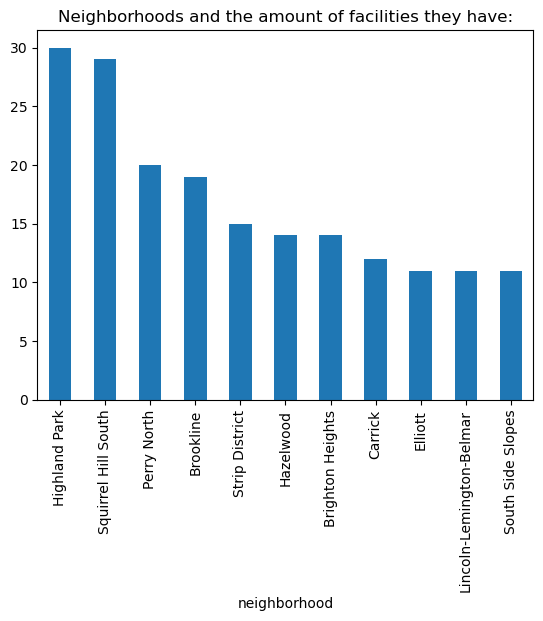

In [47]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas
data = pd.read_csv("https://data.wprdc.org/datastore/dump/fbb50b02-2879-47cd-abea-ae697ec05170")
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

facility = data.groupby("neighborhood")
facility_amt = facility.size().sort_values(ascending=False)
amt_query_mask = facility_amt > 10
facility_amt[amt_query_mask].plot.bar(title="Neighborhoods and the amount of facilities they have:")
# CHANGE AXIS LATER
plt.show()

Of all the neighborhoods in Pittsburgh, just 11 of them have more than 10 public facilities.

In case you don't want to crane your neck, those 2 big bars are Squirrel Hill South and Highland Park, both of which are coming in at a whopping [INSERT AMOUNT OF FACILITIES].

Below is a heat map, showing physically where these places are.

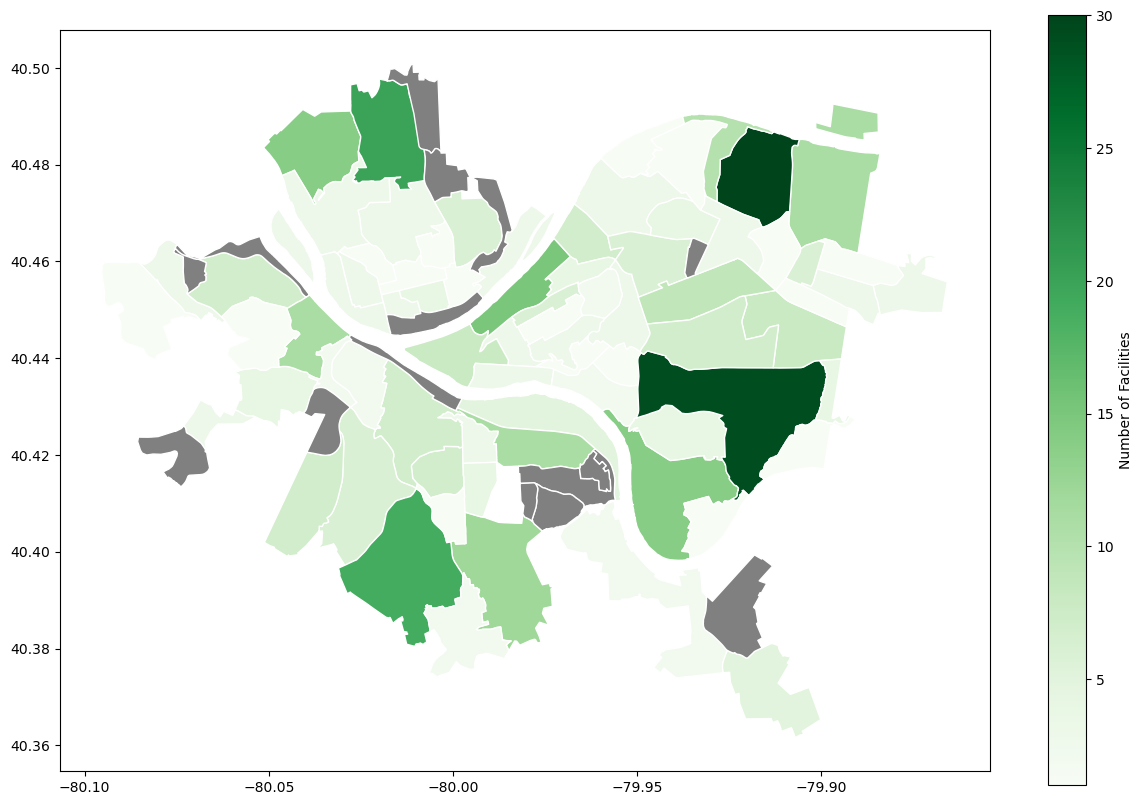

In [48]:
facility_amt.name = "facAmt"
#facility_amt.head()
facilities_map = neighborhoods.merge(facility_amt, how='left', left_on='hood', right_on='neighborhood')
pd.set_option('display.max_columns', None)

facilities_map.plot(column='facAmt', # set the data to be used for coloring
               cmap="Greens",              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Facilities"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "gray"} # set disctricts with no data to gray
               )
plt.show()

But what if some facilities are worth more than others? A police station typically will offer more public service than something like a bathroom. Let's see which neighborhood has the most of some different types of facilities. First, let's get a list of all the types of facilities there are. 

In [49]:
facility_type = data.groupby("type")
print(facility_type.size())

type
Activity         18
Cabin             4
Community         3
Concession       32
Dugout           42
Firehouse        28
Medic Station    11
OFFICE            2
Office           23
POLICE            7
Police            8
Pool             26
Pool Closed       4
Pool/Rec          6
Rec Center        6
Recycling         3
Restrooms        18
SERVICE           3
STORAGE           6
Salt Dome         8
Senior           16
Service          27
Shelter          62
Storage          24
TRAINING          2
Training          2
Utility          20
Vacant            1
dtype: int64


Some of these facilities definately look like they are more important than others. Also, there seems to be a lot of smaller buildings (like dugout, concessions) that, while helpful, do not have as much impact as a police station. However, they are still weighted the same, so a neighborhood with, say, 3 police stations is still scored less than one with 5 dugouts. Let's change that.  


Let's make a graph, but taking out a bunch of the columns that aren't as important or impactful. Things like offices and storage areas, while nice for the people who use them, do not neccessarily directly benefit the community they are located in. So, let's remove every building that does not directly impact the community. Here are the categories we will remove: OFFICE, Office, Salt Dome, TRAINING, Training, Pool Closed, Vacant, Storage, STORAGE, SERVICE, Service

If you'd like a more in depth explanation on why I cut out some things but kept some others, feel free to ask. 

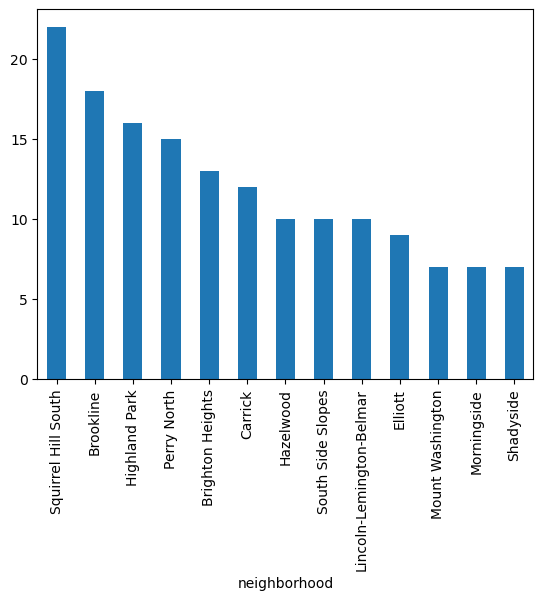

In [52]:
least_important = ["OFFICE", "Office", "Salt Dome", "TRAINING", "Training", "Pool Closed", "Vacant", "Storage", "STORAGE", "SERVICE", "Service"]
data_filtered = data[~data["type"].isin(least_important)]
data_filtered_grouped = data_filtered.groupby("neighborhood")
amt_query_mask_filtered = data_filtered_grouped.size() > 6
data_size_filtered = data_filtered_grouped.size().sort_values(ascending=False)
data_size_filtered[amt_query_mask_filtered].plot.bar()
plt.show()

And, if we want to see just the MOST important buildings (the ones that we deem to provide the most value to the community), we can do that too. For this one, we'll remove these categories: Concession, Dugout, Shelter, Cabin, Restrooms, Utility

Again, if you want to know why we removed some things but not others, feel free to ask.

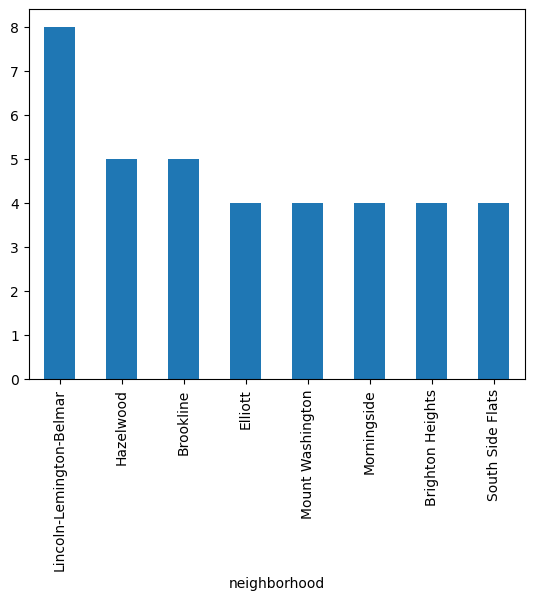

In [54]:
leastest_important = ["Concession", "Dugout", "Shelter", "Cabin", "Restrooms", "Utility"]
data_filtered_more = data_filtered[~data_filtered["type"].isin(leastest_important)]
#data_filtered_more.count().head()
data_filtered_grouped_again = data_filtered_more.groupby("neighborhood")
#data_filtered_grouped_again.size().head(30)
amt_query_mask_filtered_again = data_filtered_grouped_again.size() > 3
data_size_filtered_more = data_filtered_grouped_again.size().sort_values(ascending=False)
data_size_filtered_more[amt_query_mask_filtered_again].plot.bar()
plt.show()

With just the categories that we have deemed most important, these are top neighborhoods. These neighborhoods have 3 or more important public facilities. As you can see, Lincoln-Lemington-Belmar stands out above the rest.

But, maybe it is important to take into account the total number of all facilites. So, let's graph it. To do this, I'm going to weight them as follows: 25% of the graph will be from all facilities, and the remaining 75% will be just from the important ones. This will show us the neighborhood with the most amount of important facilities, while also taking into account the amount of total facilities.

/scratch/slurm-22215/ipykernel_1479911/1558003202.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_graphthis[merged_mask].plot(kind='bar',stacked=True,ylabel='Stacked Proportion',title='Counts by Source (Stacked)')


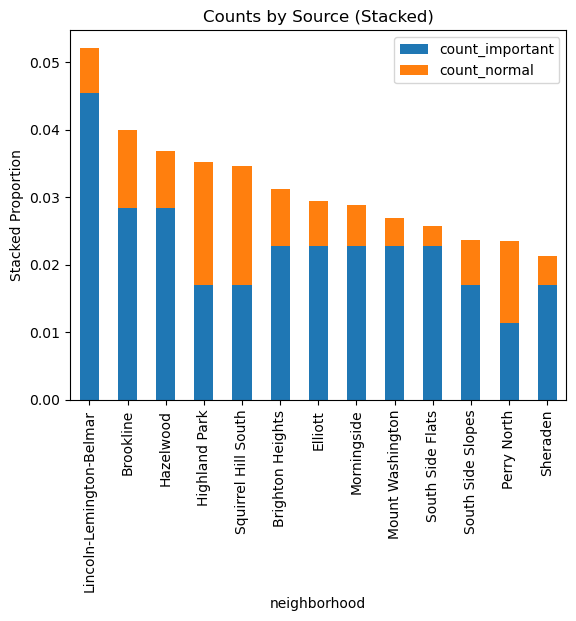

In [41]:
# Jack A
facilities = data["neighborhood"].value_counts().sort_values(ascending=False) 
facilities_weighted = 0.25 * facilities / 412
#facilities_mask = facilities_weighted > 0.012
#facilities_weighted = facilities_weighted[facilities_mask]
#print(facilities.head())
#facilities_query_mask = facilities_weighted > 0.02

# Jack B
least_important = ["OFFICE", "Office", "Salt Dome", "TRAINING", "Training", "Pool Closed", "Vacant", "Storage", "STORAGE", 
                   "SERVICE", "Service", "Concession", "Dugout", "Shelter", "Cabin", "Restrooms", "Utility"]
data_filtered = data[~data["type"].isin(least_important)]
data_filtered_grouped = data_filtered["neighborhood"].value_counts().sort_values(ascending=False)
important_facilities = 0.75 * (data_filtered_grouped / 132)
#important_mask = important_facilities > 0.012
#important_facilities = important_facilities[important_mask]

merged = pd.merge(important_facilities, facilities_weighted, on='neighborhood', how='outer', suffixes=('_important', '_normal')).fillna(0)
merged['total'] = merged['count_important'] + merged['count_normal']
merged_mask = merged['count_important'] + merged['count_normal'] > 0.02
merged = merged.sort_values('total', ascending=False)

merged_graphthis = merged.drop('total', axis=1)
merged_graphthis[merged_mask].plot(kind='bar',stacked=True,ylabel='Stacked Proportion',title='Counts by Source (Stacked)')
plt.show()

It seems that overall, Lincoln-Lemington-Belmar is the neighborhood with both the most amount of important public facilities AND facilities overall. Let's go deeper into what this neighborhood has to offer.

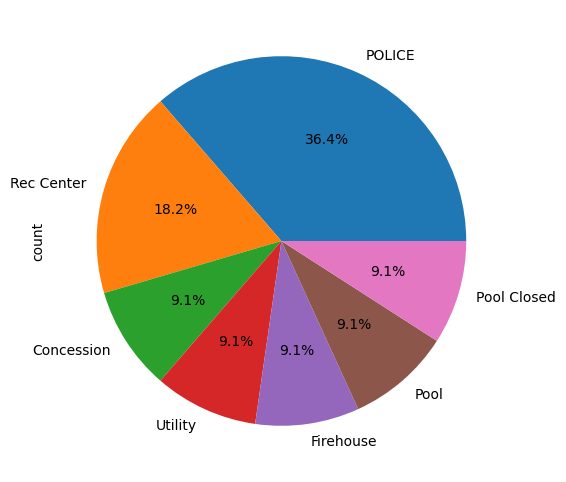

In [45]:
lincoln_data = data[data["neighborhood"]  == "Lincoln-Lemington-Belmar"]
type_counts = lincoln_data["type"].value_counts()
plt.figure(figsize=(6, 6))
type_counts.plot(kind="pie", autopct="%1.1f%%")
plt.show()

This is all of the facilities that Lincoln-Lemington-Belmar has. It seems like a lot of the facilities are mostly to do with police and recreation. These are facilities that were labelled as important, which probably explains why it's so high on that list. 
Speaking of which, here are the most important facilities Lincoln-Lemington-Belmar has:

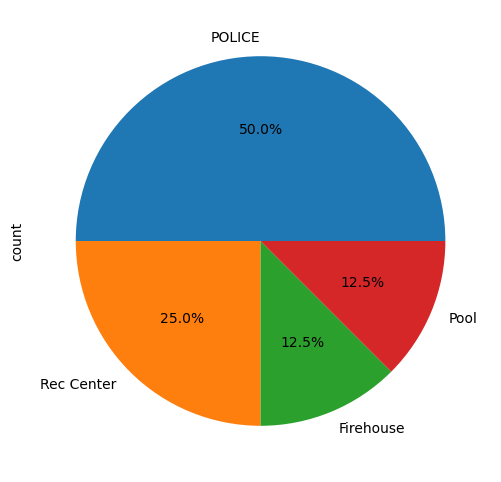

In [44]:
all_less_important = ["OFFICE", "Office", "Salt Dome", "TRAINING", "Training", "Pool Closed", "Vacant", "Storage", "STORAGE", 
                   "SERVICE", "Service", "Concession", "Dugout", "Shelter", "Cabin", "Restrooms", "Utility"]
data_filtered = data[~data["type"].isin(all_less_important)]
lincoln_data = data_filtered[data_filtered["neighborhood"]  == "Lincoln-Lemington-Belmar"]
type_counts = lincoln_data["type"].value_counts()
plt.figure(figsize=(6, 6))
type_counts.plot(kind="pie", autopct="%1.1f%%")
plt.show()

Half of Lincoln-Lemington-Belmar's important facilities come from its 4 police statons. This is really interesting that it has 4, considering it is not too large of a neighborhood. I was not able to find a reason why after doing some reasearch, so it is likely that the police stations are for neighboring neighborhoods (haha).

Here are some geopandas maps of the important facilities, filtered 0, 1, then 2 times:

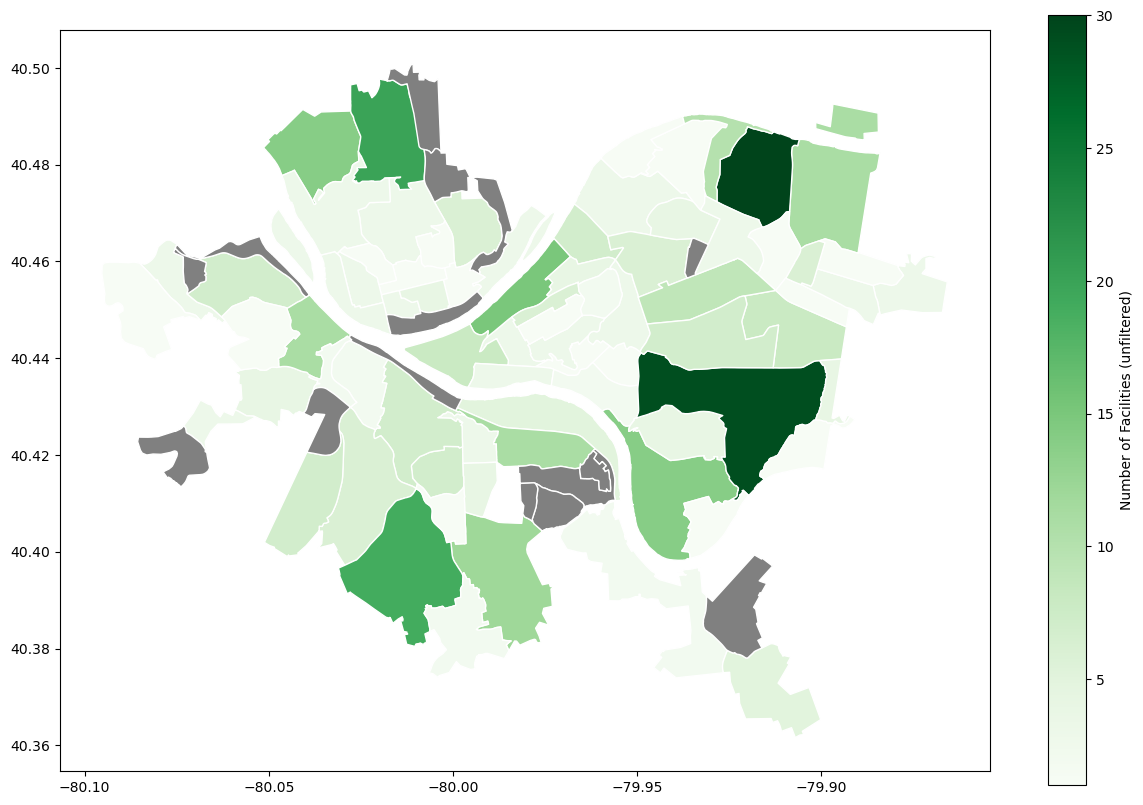

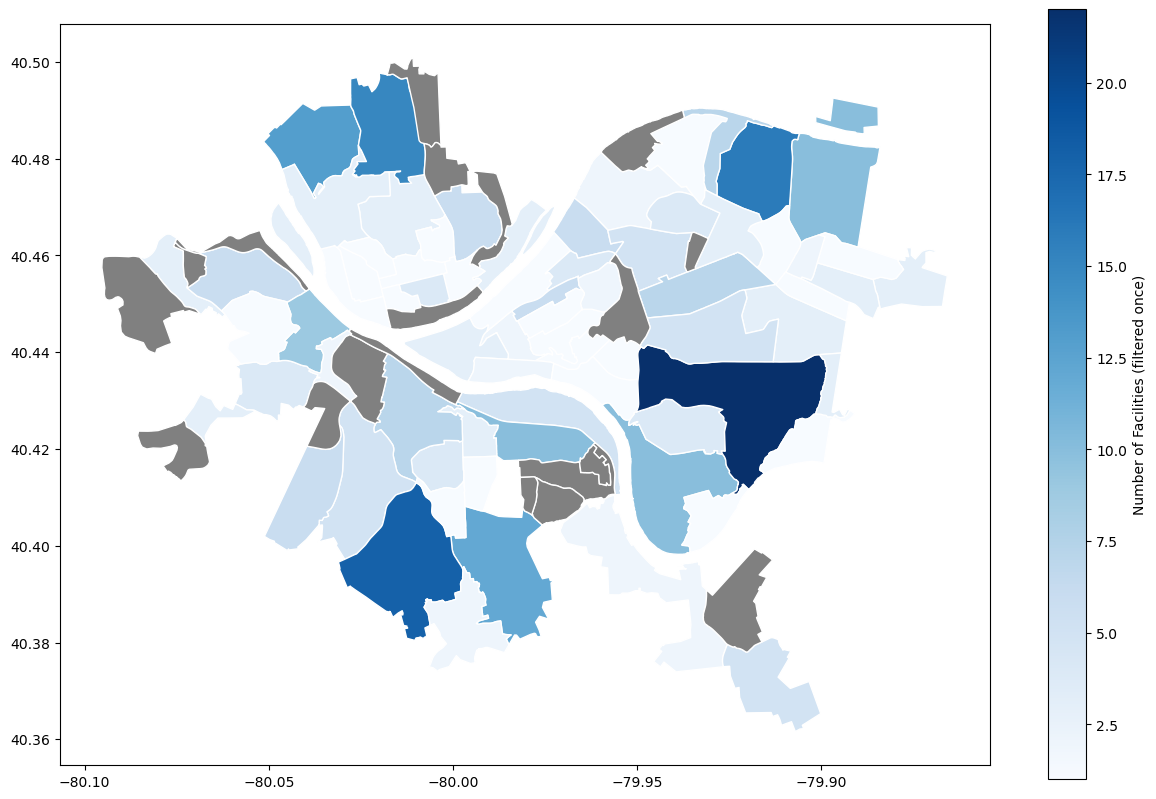

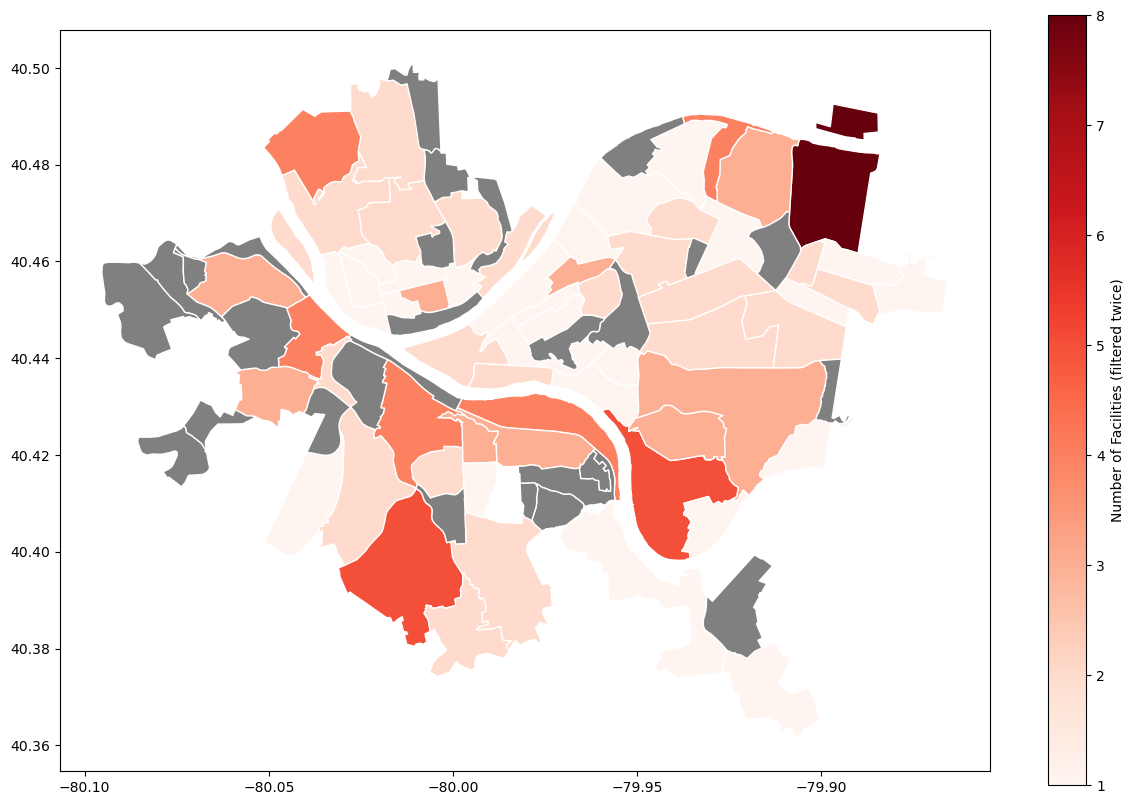

In [64]:
facility_amt.name = "facAmt"
facilities_map = neighborhoods.merge(facility_amt, how='left', left_on='hood', right_on='neighborhood')
pd.set_option('display.max_columns', None)
facilities_map.plot(column='facAmt', # set the data to be used for coloring
               cmap="Greens",              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Facilities (unfiltered)"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "gray"} # set disctricts with no data to gray
               )
plt.show()
data_size_filtered.name = "DSF"
facilities_map = neighborhoods.merge(data_size_filtered, how='left', left_on='hood', right_on='neighborhood')
pd.set_option('display.max_columns', None)

facilities_map.plot(column='DSF', # set the data to be used for coloring
               cmap="Blues",              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Facilities (filtered once)"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "gray"} # set disctricts with no data to gray
               )

data_size_filtered_more.name = "DSF2"
facilities_map = neighborhoods.merge(data_size_filtered_more, how='left', left_on='hood', right_on='neighborhood')
pd.set_option('display.max_columns', None)

facilities_map.plot(column='DSF2', # set the data to be used for coloring
               cmap="Reds",              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Number of Facilities (filtered twice)"}, # label the legend
               figsize=(15, 10),         # set the size
               missing_kwds={"color": "gray"} # set disctricts with no data to gray
               )
plt.show()

Test Stuff

# TODO

stacked bar charts, with neighborhood x, count y, then type of facility for stacked bar chart

Label/jazz up stuff